# 04  Composite Risk Index

## Objective
The goal of this notebook is to combine multiple early-warning
risk signals into a single composite risk index.

The index is designed to:
- Quantify overall market stress
- Rise before deep crash regimes
- Remain interpretable and transparent

This is a risk detection system, not a price prediction model.


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("btc_daily.csv", index_col="date", parse_dates=True)

# Recompute drawdowns
df['rolling_peak'] = df['close'].cummax()
df['drawdown'] = (df['close'] - df['rolling_peak']) / df['rolling_peak']

Volume Stress

In [119]:
df['volume_ma'] = df['volume'].rolling(30).mean()
df['volume_ratio'] = df['volume'] / df['volume_ma']

Volita;ity Stress

In [120]:
df['returns'] = df['close'].pct_change()
df['volatility_30d'] = df['returns'].rolling(30).std()

Drawdown Momentum

In [121]:
df['drawdown_change'] = df['drawdown'].diff()

Normalising

In [122]:
def rolling_percentile(series, window=252):
    return series.rolling(window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1],raw=False)

df['volume_score'] = rolling_percentile(df['volume_ratio'])
df['volatility_score'] = rolling_percentile(df['volatility_30d'])
df['drawdown_momentum_score'] = rolling_percentile(df['drawdown_change'])

Now each between 0 and 1

In [123]:
df['risk_index'] = (
    df['volume_score'] +
    df['volatility_score'] +
    df['drawdown_momentum_score']) / 3

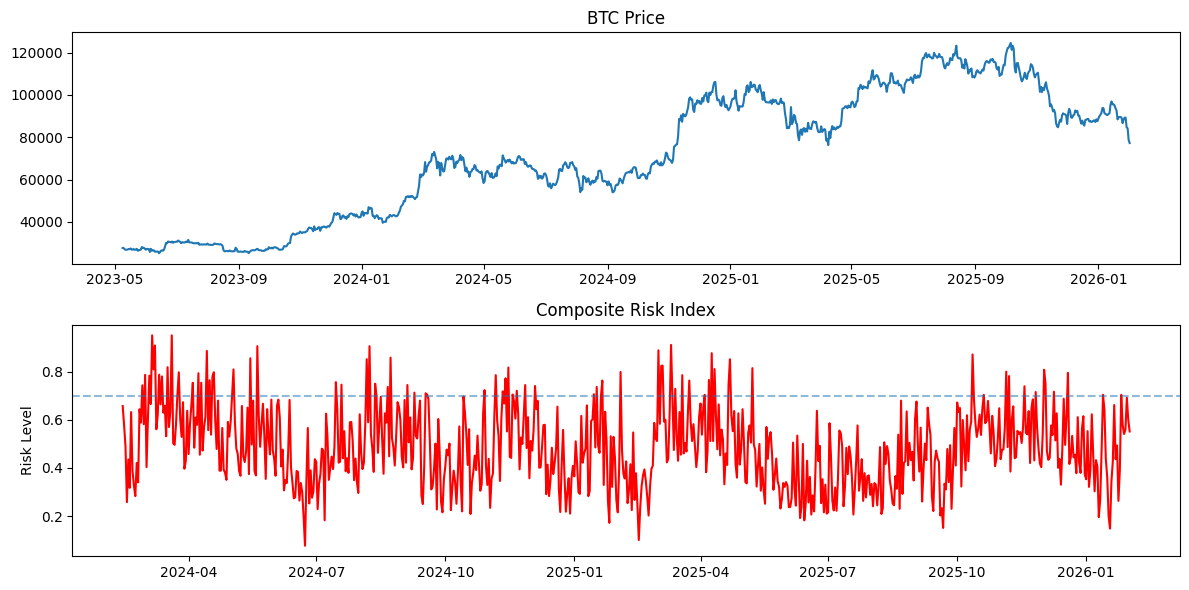

In [124]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df.index, df['close'])
plt.title("BTC Price")

plt.subplot(2,1,2)
plt.plot(df.index, df['risk_index'], color='red')
plt.axhline(0.7, linestyle='--', alpha=0.5)
plt.title("Composite Risk Index")
plt.ylabel("Risk Level")

plt.tight_layout()
plt.show()

## Risk Index Interpretation

- Risk Index < 0.4 = Low stress
- Risk Index 0.4–0.7 = Elevated stress
- Risk Index > 0.7 = High-risk regime

Sustained high values often precede or coincide
with deep drawdowns and crash regimes.


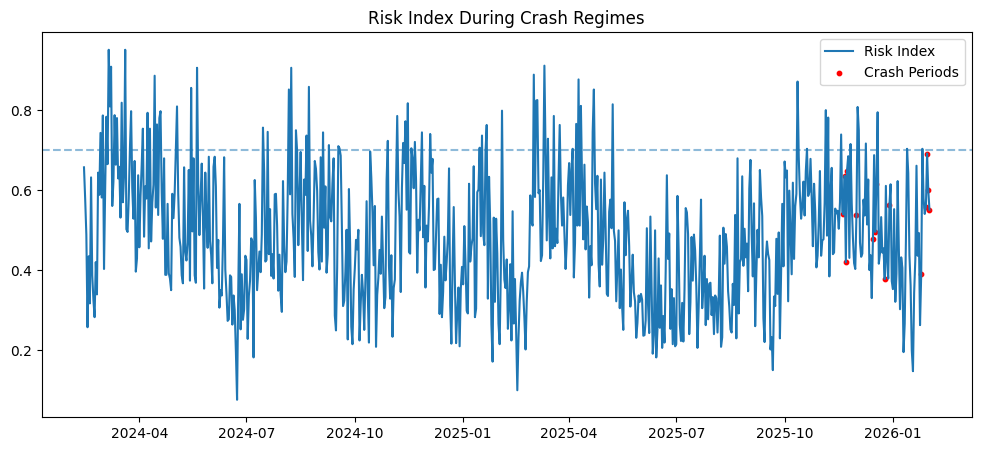

In [125]:
crash_periods = df[df['drawdown'] <= -0.3]

plt.figure(figsize=(12,5))
plt.plot(df.index, df['risk_index'], label="Risk Index")
plt.scatter(crash_periods.index,
            df.loc[crash_periods.index, 'risk_index'],
            color='red', s=10, label="Crash Periods")

plt.axhline(0.7, linestyle='--', alpha=0.5)
plt.legend()
plt.title("Risk Index During Crash Regimes")
plt.show()

## Key Conclusions

- Individual risk signals are noisy on their own
- Combining multiple stress indicators improves reliability
- The composite risk index rises before and during crash regimes
- The system detects market stress without predicting price

This framework prioritizes interpretability and robustness
over complexity or overfitting.


## Design Choice & Limitations

The composite risk index is intentionally conservative.
It prioritizes confirmation of high-risk regimes over early but noisy signals.

This design reduces false alarms at the cost of delayed warnings.
The framework can be tuned for earlier detection by adjusting
rolling windows and signal weights, but this was intentionally avoided
to preserve robustness and interpretability.
